Mapping Sentinel-1 backscatter (VV and VH) over Kingman Farm.  

This notebook visualizes Sentinel-1 GeoTIFF images (VV/VH polarization)
over the Kingman Farm boundary using rasterio and geopandas.

**You will need to install geopandas and rasterio  
write the below sentence in your Anaconda Prompt  
conda install geopandas rasterio matplotlib numpy -c conda-forge


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from pathlib import Path

In [14]:
base_dir = Path(".")
vv_dir = base_dir / "VV"        # VV GeoTIFF 
vh_dir = base_dir / "VH"        # VH GeoTIFF 
boundary_file = base_dir / "Kingman_Farm_boundary" / "Kingman_Farm_boundary"/ "Kingman_Farm_boundary.shp"

In [15]:
boundary = gpd.read_file(boundary_file).to_crs(epsg=32619)
boundary_style = dict(edgecolor='black', facecolor='none', linewidth=1.2, zorder=5)

In [16]:
# Select polarization (VV or VH)

polarization = "VH" # VV   
data_dir = vh_dir if polarization == "VH" else vv_dir

# Load file
files = sorted(list(data_dir.glob("*.tif"))) #list of GeoTIFF files
files = sorted(data_dir.glob("*.tif"))
if not files:
    raise FileNotFoundError(f"No .tif files ")
print(f"{len(files)} {polarization} images")

Loaded 36 VH images


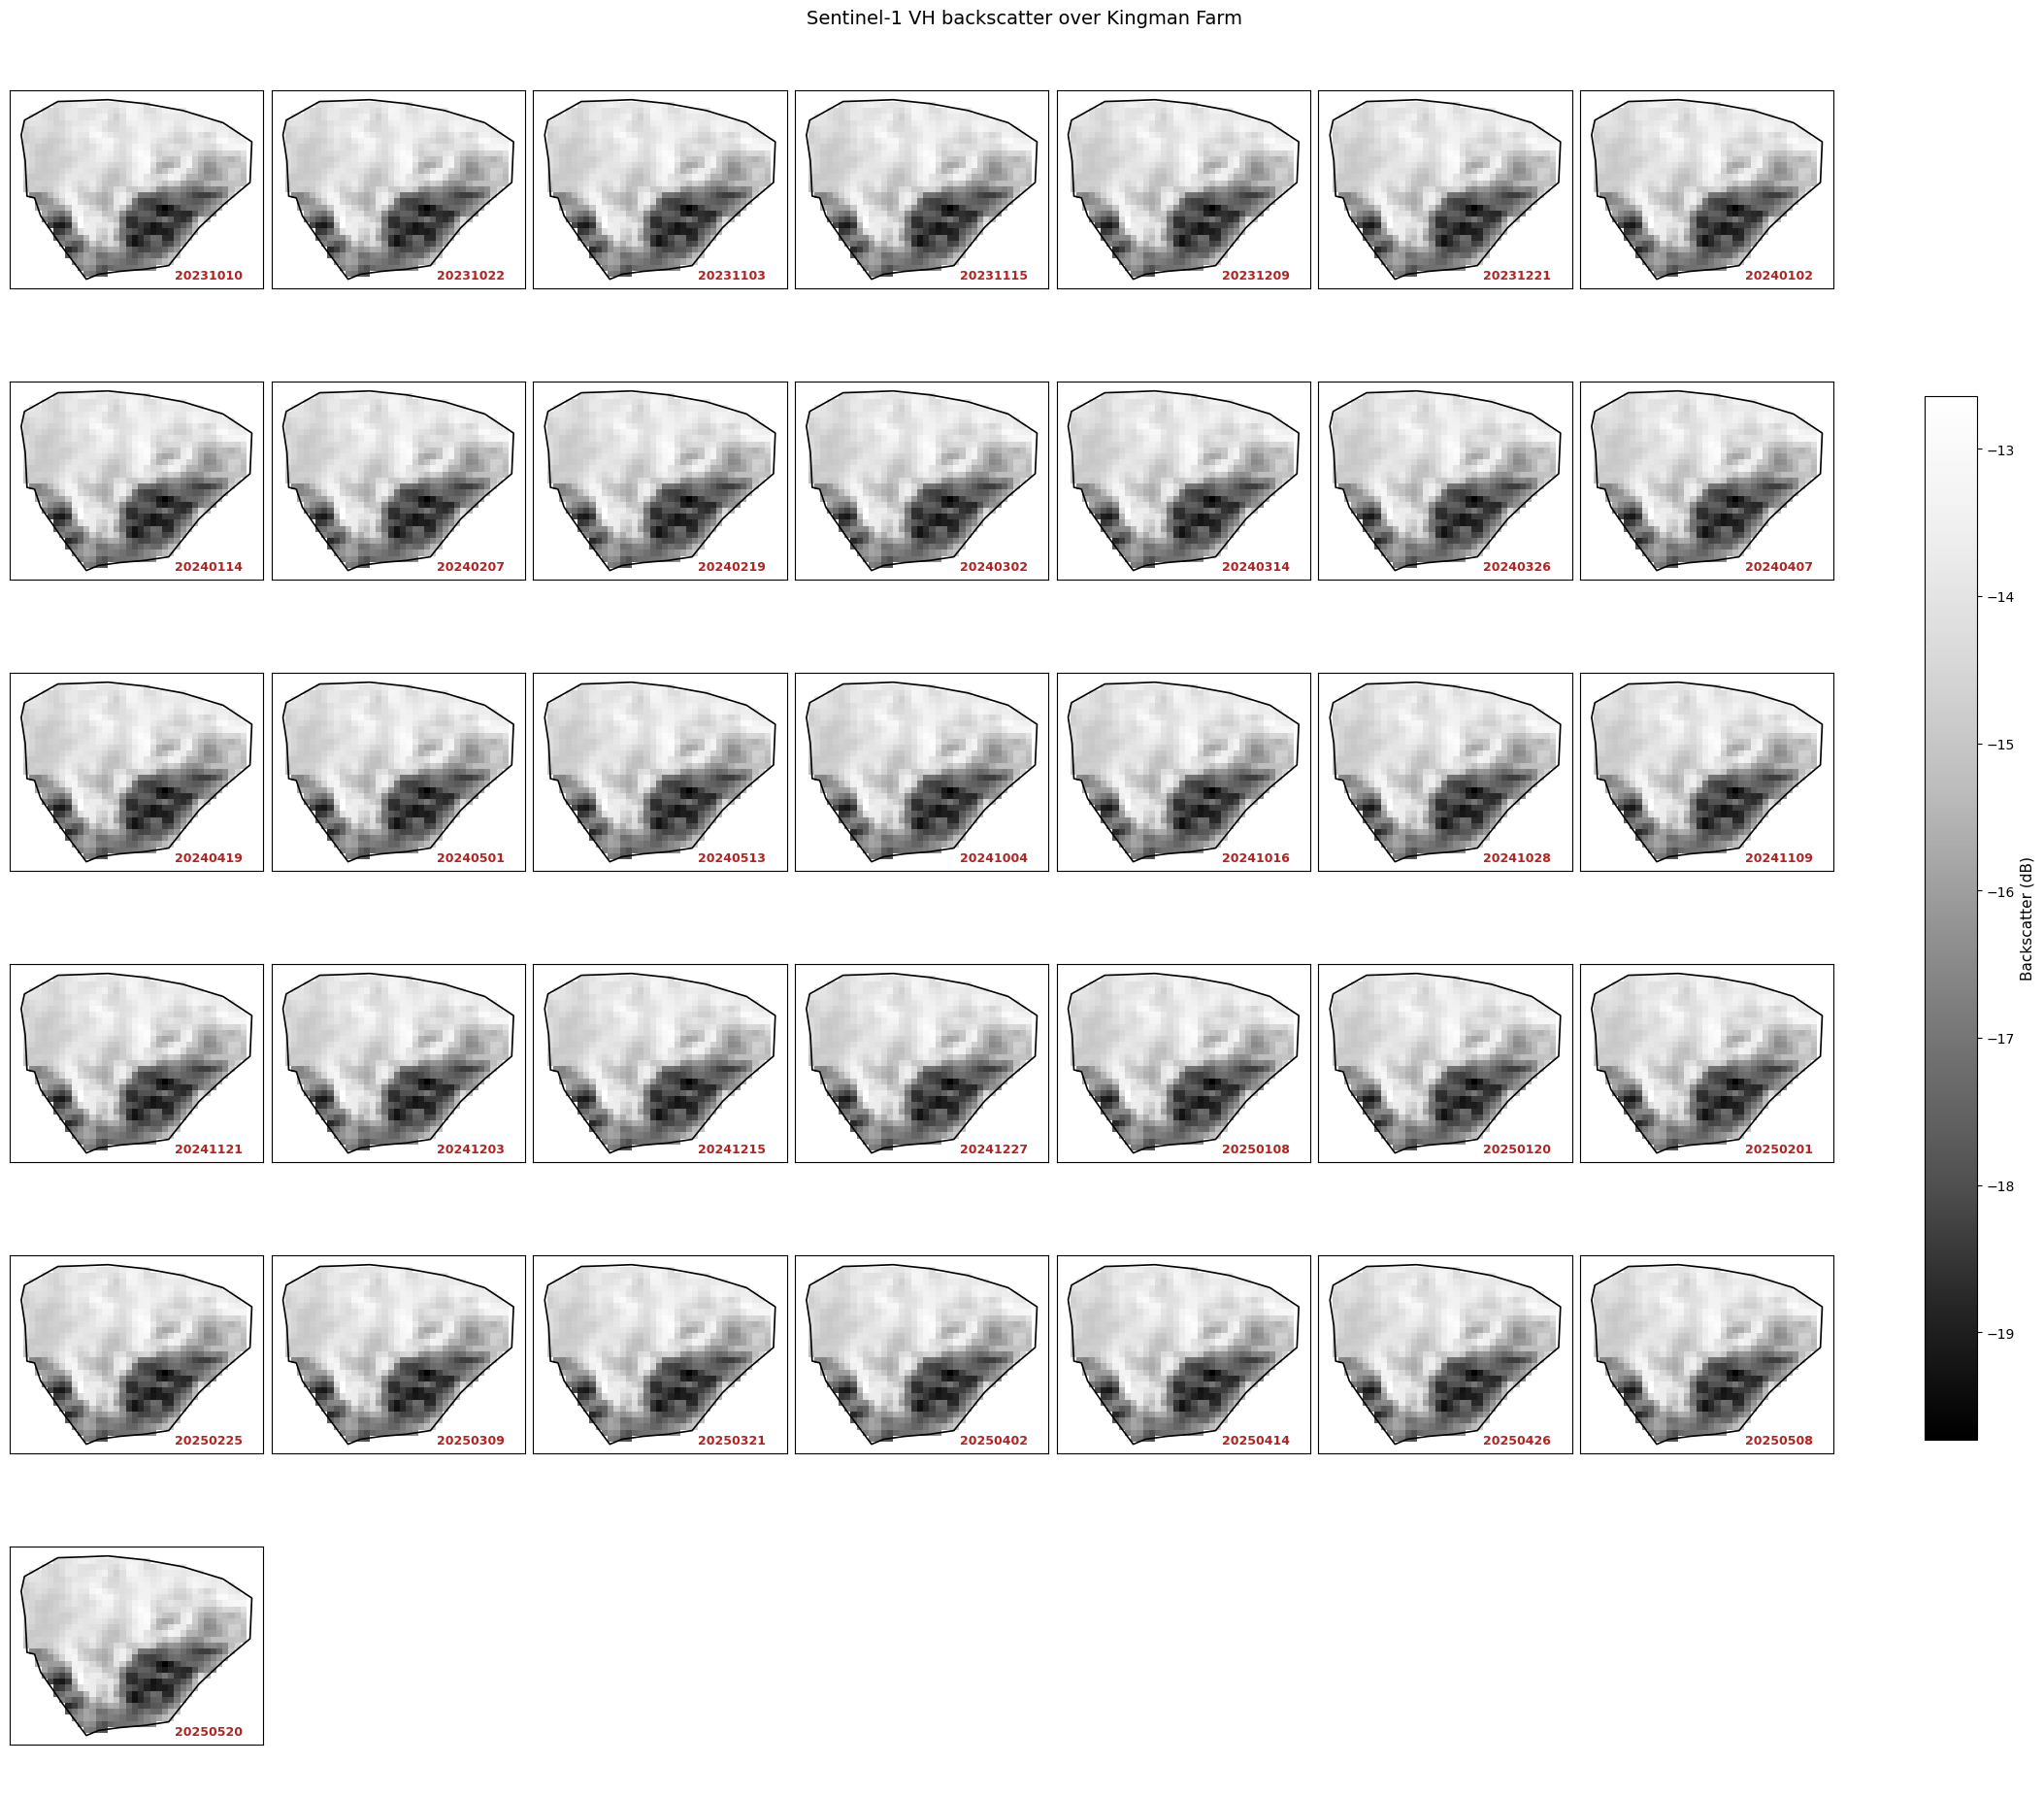

In [18]:
# Mapping sentinel-1 

n = len(files)
cols = 7
rows = int(np.ceil(n / cols))
figsize_per_tile = 3.0
fig_all, axes = plt.subplots(rows, cols,
                             figsize=(cols * figsize_per_tile, rows * figsize_per_tile),
                             constrained_layout=True)
axes = axes.flatten()

#initialize value to keep the minimum and maximum values across all images.
#Since dB values include negative numbers, set +/- infinite.
vmin, vmax = np.inf, -np.inf 

for i, f in enumerate(files): # give both the index (i) and the file path (f)
    with rasterio.open(f) as src: #open GeoTIFF using the rasterio library and automatically closes the file after reading
        sar = src.read(1).astype(float) # read 1st band and converts it to float (floats are needed for log10)
        sar[sar <= 0] = np.nan # 'sar' contains backscatter values
        sar_dB = 10 * np.log10(arr) # convert unit (desibel)
        extent = [ # defines the geographic information of the image (map coordinates).
            src.transform[2], #left (x_min)
            src.transform[2] + src.transform[0] * src.width, # move width * pixel size step to right (x_max) 
            src.transform[5] + src.transform[4] * src.height, # move height * pixel size step to bottom down (y_min)
            src.transform[5],# top (y_max)
        ]
    vmin = min(vmin, np.nanmin(sar_dB))
    vmax = max(vmax, np.nanmax(sar_dB))
    ax = axes[i]
    im = ax.imshow(sar_dB, extent=extent, origin="upper", cmap="Greys_r", vmin=vmin, vmax=vmax)
    boundary.plot(ax=ax, **boundary_style)

    date_str = f.stem.split("_")[2][:8] if len(f.stem.split("_")) > 2 else f.stem
    ax.text(0.65, 0.05, date_str, color="firebrick", fontsize=9, fontweight="bold", transform=ax.transAxes)
    ax.set_xticks([]); ax.set_yticks([])

# Turn off empty axes
for ax in axes[len(files):]:
    ax.axis("off")

# colorbar
cbar = fig_all.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.set_label("Backscatter (dB)", fontsize=11)

plt.suptitle(f"Sentinel-1 {polarization} backscatter over Kingman Farm", fontsize=14, y=1.02)
plt.show()

--------------------------------------
supplementary explain code  
mapping information is stored in "src.transform"   

transform[0]:pixel size  
transform[2]: X coordinate (upper-left)  
transform[5]: Y coordinate (upper-left corner)



In [19]:
src.transform

Affine(30.0, 0.0, 342750.0,
       0.0, -30.0, 4782240.0)

In [20]:
src.width

37

In [21]:
src.height

29